In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
df = pd.read_csv("crypto_mining_dataset.csv")

print("Shape:", df.shape)
df.head()


Shape: (42521, 10)


,asset_id,symbol,name,timestamp,price_usd,vol_24h,total_vol,chg_24h,chg_7d,market_cap
0,1,leo,LEO Token,2025-04-10 10:52:00,9.64,585600.0,0.0,0.0035,0.0153,8889220000
1,1,leo,LEO Token,2025-04-10 11:43:00,9.63,579616.0,0.0,0.0027,0.0137,8887440000
2,1,leo,LEO Token,2025-04-10 12:38:00,9.62,623116.0,0.0,0.0032,0.0126,8888920000
3,1,leo,LEO Token,2025-04-10 13:20:00,9.64,564788.0,0.0,0.0026,0.0148,8894800000
4,1,leo,LEO Token,2025-04-10 13:40:00,9.64,564810.0,0.0,0.0024,0.0148,8895180000


In [25]:
features = [
    "price_usd",
    "vol_24h",
    "market_cap",
    "chg_24h",
    "chg_7d"
]

df_mine = df[features].copy()

df_mine.head()


,price_usd,vol_24h,market_cap,chg_24h,chg_7d
0,9.64,585600.0,8889220000,0.0035,0.0153
1,9.63,579616.0,8887440000,0.0027,0.0137
2,9.62,623116.0,8888920000,0.0032,0.0126
3,9.64,564788.0,8894800000,0.0026,0.0148
4,9.64,564810.0,8895180000,0.0024,0.0148


In [26]:
# Binning 3 khoảng bằng quantile
for col in features:
    df_mine[col + "_bin"] = pd.qcut(df_mine[col], 3, labels=["low","mid","high"])

df_bins = df_mine[[c+"_bin" for c in features]]
df_bins.head()


,price_usd_bin,vol_24h_bin,market_cap_bin,chg_24h_bin,chg_7d_bin
0,mid,low,mid,mid,mid
1,mid,low,mid,mid,mid
2,mid,low,mid,mid,mid
3,mid,low,mid,mid,mid
4,mid,low,mid,mid,mid


In [27]:
df_hot = pd.get_dummies(df_bins)

print("Shape (one-hot):", df_hot.shape)
df_hot.head()


Shape (one-hot): (42521, 15)


,price_usd_bin_low,price_usd_bin_mid,price_usd_bin_high,vol_24h_bin_low,vol_24h_bin_mid,vol_24h_bin_high,market_cap_bin_low,market_cap_bin_mid,market_cap_bin_high,chg_24h_bin_low,chg_24h_bin_mid,chg_24h_bin_high,chg_7d_bin_low,chg_7d_bin_mid,chg_7d_bin_high
0,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False
1,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False
2,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False
3,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False
4,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False


In [28]:
frequent = apriori(df_hot, min_support=0.1, use_colnames=True)

print("Số lượng tập thường xuyên:", frequent.shape)
frequent.sort_values("support", ascending=False).head()


Số lượng tập thường xuyên: (76, 2)


,support,itemsets
0,0.378872,(price_usd_bin_low)
9,0.333670,(chg_24h_bin_low)
4,0.333529,(vol_24h_bin_mid)
13,0.333506,(chg_7d_bin_mid)
8,0.333341,(market_cap_bin_high)


In [29]:
rules = association_rules(frequent, metric="lift", min_threshold=1.0)

print("Tổng số luật tìm được:", rules.shape)
rules.head()


Tổng số luật tìm được: (110, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(price_usd_bin_low),(vol_24h_bin_mid),0.378872,0.333529,0.136168,0.359404,1.077579,1.0,0.009803,1.040392,0.115908,0.236307,0.038824,0.383834
1,(vol_24h_bin_mid),(price_usd_bin_low),0.333529,0.378872,0.136168,0.408264,1.077579,1.0,0.009803,1.049671,0.108022,0.236307,0.047321,0.383834
2,(price_usd_bin_low),(market_cap_bin_high),0.378872,0.333341,0.139719,0.368777,1.106305,1.0,0.013426,1.056139,0.154703,0.244054,0.053155,0.393962
3,(market_cap_bin_high),(price_usd_bin_low),0.333341,0.378872,0.139719,0.419148,1.106305,1.0,0.013426,1.069340,0.144137,0.244054,0.064843,0.393962
4,(chg_24h_bin_mid),(price_usd_bin_low),0.333059,0.378872,0.178124,0.534811,1.411590,1.0,0.051937,1.335219,0.437189,0.333686,0.251059,0.502477


In [30]:
rules_filtered = rules[
    (rules["lift"] > 1.2) &
    (rules["confidence"] > 0.7)
].sort_values("lift", ascending=False)

print("Số luật sau khi lọc:", rules_filtered.shape)
rules_filtered.head(20)


Số luật sau khi lọc: (12, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
92,"(price_usd_bin_high, vol_24h_bin_high)",(market_cap_bin_high),0.151196,0.333341,0.145928,0.965158,2.895406,1.0,0.095528,19.133704,0.771232,0.430963,0.947736,0.701466
93,"(price_usd_bin_high, market_cap_bin_high)",(vol_24h_bin_high),0.156393,0.333130,0.145928,0.933083,2.800961,1.0,0.093829,9.965593,0.762179,0.424709,0.899655,0.685567
98,"(chg_24h_bin_mid, vol_24h_bin_high)",(market_cap_bin_high),0.138002,0.333341,0.126714,0.918200,2.754536,1.0,0.080712,8.149904,0.738938,0.367681,0.877299,0.649167
104,"(chg_7d_bin_mid, vol_24h_bin_high)",(market_cap_bin_high),0.135227,0.333341,0.123633,0.914261,2.742718,1.0,0.078556,7.775433,0.734757,0.358424,0.871390,0.642576
99,"(chg_24h_bin_mid, market_cap_bin_high)",(vol_24h_bin_high),0.139954,0.333130,0.126714,0.905394,2.717844,1.0,0.080091,7.048928,0.734916,0.365834,0.858134,0.642884
105,"(chg_7d_bin_mid, market_cap_bin_high)",(vol_24h_bin_high),0.137556,0.333130,0.123633,0.898786,2.698008,1.0,0.077809,6.588725,0.729735,0.356238,0.848226,0.634956
53,(market_cap_bin_high),(vol_24h_bin_high),0.333341,0.333130,0.290351,0.871031,2.614693,1.0,0.179305,5.170800,0.926330,0.771963,0.806606,0.871308
52,(vol_24h_bin_high),(market_cap_bin_high),0.333130,0.333341,0.290351,0.871585,2.614693,1.0,0.179305,5.191436,0.926036,0.771963,0.807375,0.871308
82,"(price_usd_bin_low, vol_24h_bin_high)",(market_cap_bin_high),0.124080,0.333341,0.107406,0.865618,2.596793,1.0,0.066045,4.960920,0.702016,0.306860,0.798424,0.593914
87,"(chg_24h_bin_mid, price_usd_bin_low)",(chg_7d_bin_mid),0.178124,0.333506,0.142447,0.799710,2.397888,1.0,0.083042,3.327638,0.709312,0.385845,0.699487,0.613415


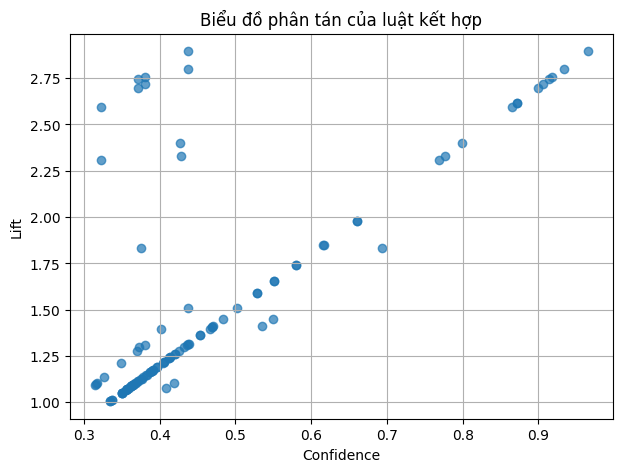

In [31]:
plt.figure(figsize=(7,5))
plt.scatter(rules["confidence"], rules["lift"], alpha=0.7)
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.title("Biểu đồ phân tán của luật kết hợp")
plt.grid(True)
plt.show()


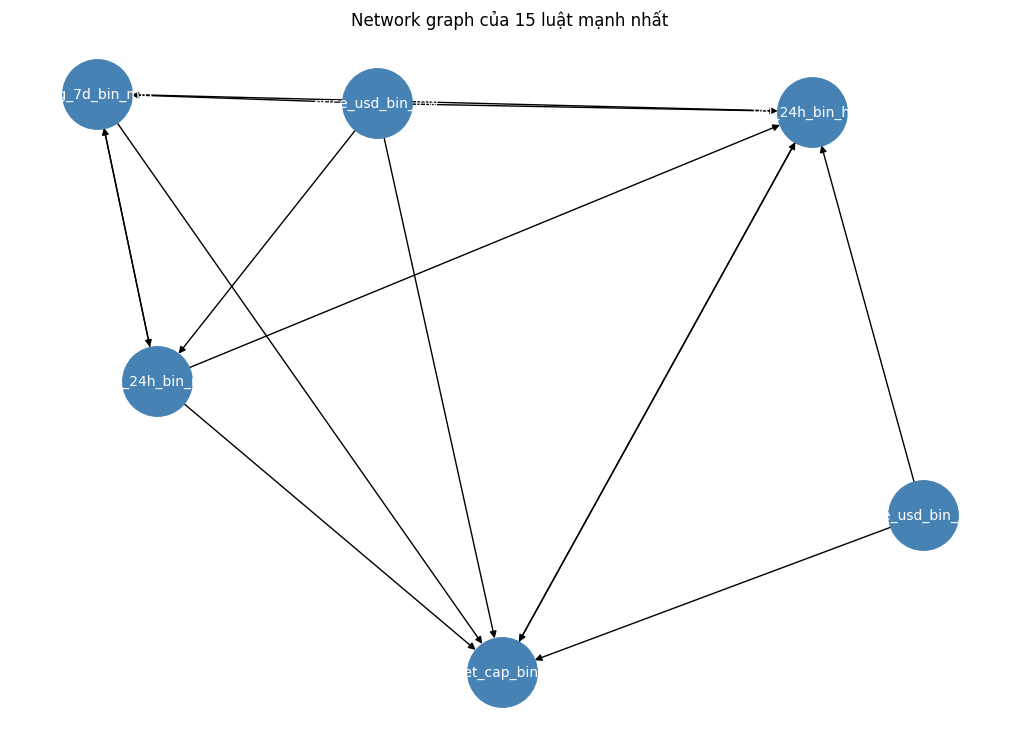

In [32]:
import networkx as nx

G = nx.DiGraph()

for _, row in rules_filtered.head(15).iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(10,7))
pos = nx.spring_layout(G, k=0.4)
nx.draw(G, pos, with_labels=True, node_size=2500, font_size=10,
        font_color='white', node_color='steelblue', arrows=True)

plt.title("Network graph của 15 luật mạnh nhất")
plt.show()
